In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()
# Нормализация данных
test_images = test_images / 255.0
# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)
# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')
# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9718 - loss: 0.0973
Test accuracy on clean images: 0.9753000140190125


In [2]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.2 MB/s eta 0:00:00


In [8]:
import foolbox as fb
import tensorflow as tf
import numpy as np
image = tf.convert_to_tensor(test_images[0].reshape(1, 28, 28, 1), dtype=tf.float32)
label = np.argmax(test_labels[0])
# Инициализация Foolbox модели
fmodel = fb.models.TensorFlowModel(model, bounds=(0, 1))
# Создание PGD-атаки
attack = fb.attacks.LinfPGD()
# Выполнение атаки
adversarial_image, _, success = attack(fmodel, image, np.array([label]), epsilons=0.1)

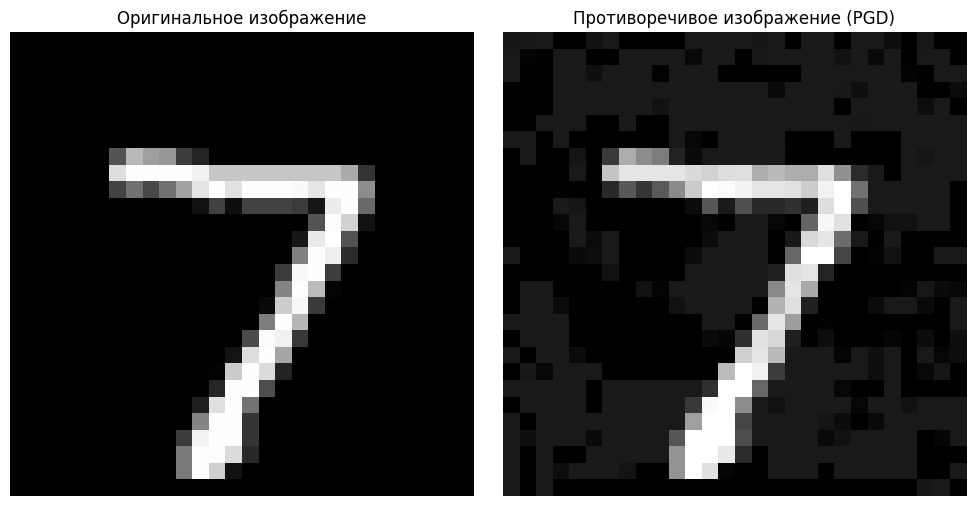

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(tf.squeeze(image).numpy(), cmap="gray")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(tf.squeeze(adversarial_image).numpy(), cmap="gray")
plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
adversarial_images = []
# Обработка изображений
for i in range(len(test_images) // 10): # ограничил выборку для ускорения выполнения
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    # Атака на изображение
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)
    adversarial_images.append(advs)
# Конвертация списка в массив с правильной формой
adversarial_images = tf.concat(adversarial_images, axis=0)
# Убедитесь, что test_labels имеют соответствующее количество меток
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:1000])
print(f'Accuracy on adversarial examples (PGD attack): {adversarial_acc}') # в выводе опечатка, атака PGD, забыл изменить

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0323 - loss: 8.3897
Accuracy on adversarial examples (CW attack): 0.03799999877810478


Была выполнена атака PGD, которая даже при незначительном изменении изображения при малом eps 0.1 снизила точность модели до 3%. Однако атака выполнялась гораздо дольше других атак, выполненых в предыдущих практиках